# Fraud Profile Analysis

This notebook analyzes the generated banking data to identify potentially fraudulent user profiles.

In [81]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
import shap

# Set style for better visualizations
plt.style.use('seaborn')
sns.set_palette('husl')

C:\Users\ADITYA\AppData\Local\Temp\ipykernel_11644\368580134.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## 1. Load and Explore the Data

In [82]:
# Load the CSV files
logins_df = pd.read_csv('dataset/logins.csv')
sessions_df = pd.read_csv('dataset/sessions.csv')
transactions_df = pd.read_csv('dataset/transactions.csv')
feature_usage_df = pd.read_csv('dataset/feature_usage.csv')

# Display basic information about each dataset
print("Logins Dataset:")
print(logins_df.info())
print("\nSessions Dataset:")
print(sessions_df.info())
print("\nTransactions Dataset:")
print(transactions_df.info())
print("\nFeature Usage Dataset:")
print(feature_usage_df.info())



Logins Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1000 non-null   object
 1   timestamp          1000 non-null   object
 2   device_type        1000 non-null   object
 3   os_browser         1000 non-null   object
 4   screen_resolution  1000 non-null   object
 5   ip_address         1000 non-null   object
 6   geolocation        1000 non-null   object
 7   login_method       1000 non-null   object
 8   channel            1000 non-null   object
dtypes: object(9)
memory usage: 70.4+ KB
None

Sessions Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           500 non-null    object 
 1   session_id        500 non-null    object 
 2   

In [83]:
# Display first few rows of each dataset
print("\nSample of Logins Data:")
display(logins_df.head())
print("\nSample of Sessions Data:")
display(sessions_df.head())
print("\nSample of Transactions Data:")
display(transactions_df.head())
print("\nSample of Feature Usage Data:")
display(feature_usage_df.head())


Sample of Logins Data:


,user_id,timestamp,device_type,os_browser,screen_resolution,ip_address,geolocation,login_method,channel
0,USER_000064,2025-06-08 17:04:23,Desktop,iOS/Safari,414x896,32.132.88.218,"71.8933725,101.619889",Biometric,Web
1,USER_000066,2025-06-05 20:18:02,Tablet,Windows/Firefox,1440x900,1.221.9.205,"75.6954535,178.510605",Biometric,Web
2,USER_000003,2025-06-03 16:55:14,Tablet,iOS/Safari,1920x1080,120.137.133.84,"-66.358307,176.189359",Password,Tablet App
3,USER_000065,2025-06-13 05:27:29,Desktop,Windows/Chrome,1366x768,192.74.221.139,"50.405658,-61.915770",2FA,Mobile App
4,USER_000010,2025-06-10 11:02:46,Mobile,Windows/Chrome,1366x768,142.212.249.51,"19.632697,122.937942",2FA,Mobile App



Sample of Sessions Data:


,user_id,session_id,start_time,end_time,pages_visited,session_duration
0,USER_000029,SESS_651c3b22-7e28-4dd8-8960-f79e92ad6dfe,2025-06-10 02:37:30,2025-06-10 03:28:31,"['Bill Pay', 'Transfer Money', 'Card Managemen...",3061.0
1,USER_000039,SESS_22994ab1-72f1-41a8-9cd9-34890f50fe37,2025-05-25 00:33:06,2025-05-25 01:17:07,"['Statement Download', 'Bill Pay', 'Card Manag...",2641.0
2,USER_000089,SESS_c7fb011c-366a-402e-872e-1d2d04f22f35,2025-05-27 04:56:03,2025-05-27 05:54:36,"['Account Balance', 'Statement Download', 'Bil...",3513.0
3,USER_000076,SESS_f63d4a14-c180-4e03-a93a-b79aa90bd4ed,2025-05-26 07:29:00,2025-05-26 07:38:43,"['Bill Pay', 'Card Management', 'Transfer Mone...",583.0
4,USER_000003,SESS_0c65bfd1-ef69-4c54-a3e3-2746b2daa7e1,2025-05-28 15:07:35,2025-05-28 15:49:29,"['Bill Pay', 'Statement Download', 'Card Manag...",2514.0



Sample of Transactions Data:


,user_id,transaction_id,transaction_type,amount,recipient,method,timestamp
0,USER_000064,TXN_9205c6c6-f2c7-4ae9-9213-ddfa90b4d49e,Bill Payment,9691.47,Joanne Bowman,Zelle,2025-05-24 05:02:30
1,USER_000019,TXN_48875c77-1d7e-4b67-b71f-6a856ed5ed67,Bill Payment,932.12,Janice Ewing,Zelle,2025-06-03 08:13:27
2,USER_000060,TXN_712c46dd-30c5-4885-ba2e-21c6a97cb581,Transfer,8205.89,April Kim,Wire,2025-05-30 22:53:46
3,USER_000073,TXN_259d8cc5-f771-4f19-9cda-73e795355234,Bill Payment,4265.01,Sandra Clark,Wire,2025-06-05 14:25:45
4,USER_000003,TXN_8df30a92-4b16-472e-b467-b38da2e71720,Transfer,2512.86,Julie Ross,ACH,2025-05-28 04:11:24



Sample of Feature Usage Data:


,user_id,feature_name,timestamp,frequency
0,USER_000024,Transfer Money,2025-05-18 16:55:21,4
1,USER_000028,Statement Download,2025-05-17 04:53:09,4
2,USER_000005,Account Balance,2025-05-24 22:04:38,3
3,USER_000044,Card Management,2025-06-06 06:36:47,4
4,USER_000010,Bill Pay,2025-06-13 12:25:55,5


### Printing columns of dataset

In [84]:
# Check column names in each dataset
print("Logins columns:", logins_df.columns.tolist())
print("\nSessions columns:", sessions_df.columns.tolist())
print("\nTransactions columns:", transactions_df.columns.tolist())
print("\nFeature Usage columns:", feature_usage_df.columns.tolist())

Logins columns: ['user_id', 'timestamp', 'device_type', 'os_browser', 'screen_resolution', 'ip_address', 'geolocation', 'login_method', 'channel']

Sessions columns: ['user_id', 'session_id', 'start_time', 'end_time', 'pages_visited', 'session_duration']

Transactions columns: ['user_id', 'transaction_id', 'transaction_type', 'amount', 'recipient', 'method', 'timestamp']

Feature Usage columns: ['user_id', 'feature_name', 'timestamp', 'frequency']


## 2. Feature Engineering

#### check for null values of userId and remove the row if any

In [85]:
# Check for any null values in user_id
print("\nNull values in user_id:")
print("Logins:", logins_df['user_id'].isnull().sum())
print("Sessions:", sessions_df['user_id'].isnull().sum())
print("Transactions:", transactions_df['user_id'].isnull().sum())
print("Feature Usage:", feature_usage_df['user_id'].isnull().sum())


Null values in user_id:
Logins: 0
Sessions: 0
Transactions: 0
Feature Usage: 0


##### Add a feature login_interval: Represents how many seconds elapsed between each user's consecutive login attempts.

In [86]:
logins_df['timestamp'] = pd.to_datetime(logins_df['timestamp'])
login_intervals = logins_df.sort_values(['user_id', 'timestamp']).groupby('user_id')['timestamp'].diff().dt.total_seconds()
logins_df['login_interval'] = login_intervals

nan_count = logins_df['login_interval'].isna().sum()
print(f"Number of NaN values: {nan_count}")

print("filling NaN values in login_interval with median value...")
# Fill with median/mean of user's other intervals
logins_df['login_interval'] = logins_df.groupby('user_id')['login_interval'].transform(
    lambda x: x.fillna(x.median())
)

nan_count = logins_df['login_interval'].isna().sum()
print(f"Number of NaN values: {nan_count}")

Number of NaN values: 100
filling NaN values in login_interval with median value...
Number of NaN values: 0


In [87]:
def create_user_features():
    try:
        # Clean user_id in all DataFrames
        for df in [logins_df, sessions_df, transactions_df, feature_usage_df]:
            df['user_id'] = df['user_id'].astype(str).str.strip()
        
        print("\nShape of DataFrames before aggregation:")
        print("Logins:", logins_df.shape)
        print("Sessions:", sessions_df.shape)
        print("Transactions:", transactions_df.shape)
        print("Feature Usage:", feature_usage_df.shape)

        logins_df['timestamp'] = pd.to_datetime(logins_df['timestamp'])
        login_intervals = logins_df.sort_values(['user_id', 'timestamp']).groupby('user_id')['timestamp'].diff().dt.total_seconds()
        logins_df['login_interval'] = login_intervals
        
        # Login features
        login_features = logins_df.groupby('user_id').agg(
            login_count=('timestamp', 'count'),
            unique_login_times=('timestamp', 'nunique'),
            unique_devices=('device_type', 'nunique'),
            unique_ips=('ip_address', 'nunique'),
            unique_login_methods=('login_method', 'nunique'),
            unique_locations=('geolocation', 'nunique'),
            location_change_rate=('geolocation', lambda x: (x != x.shift()).sum() / len(x)),
            avg_login_interval=('login_interval', 'mean'),
            std_login_interval=('login_interval', 'std'),
            max_login_interval=('login_interval', 'max')
        ).reset_index()
        
        # Session features
        session_features = sessions_df.groupby('user_id').agg(
            avg_session_duration=('session_duration', 'mean'),
            std_session_duration=('session_duration', 'std'),
            max_session_duration=('session_duration', 'max'),
            session_count=('start_time', 'count')
        ).reset_index()
        
        # Transaction features
        transaction_features = transactions_df.groupby('user_id').agg(
            avg_transaction_amount=('amount', 'mean'),
            std_transaction_amount=('amount', 'std'),
            max_transaction_amount=('amount', 'max'),
            total_transaction_amount=('amount', 'sum'),
            transaction_count=('timestamp', 'count'),
            unique_transaction_types=('transaction_type', 'nunique')
        ).reset_index()
        
        # Feature usage features
        feature_usage_features = feature_usage_df.groupby('user_id').agg(
            unique_features_used=('feature_name', 'nunique'),
            feature_usage_count=('timestamp', 'count'),
            total_frequency=('frequency', 'sum')
        ).reset_index()
        
        
        # Print column info before merge
        print("\nBefore merge:")
        print("Login features shape:", login_features.shape)        
        print("Session features shape:", session_features.shape)        
        print("Transaction features shape:", transaction_features.shape)        
        print("Feature usage features shape:", feature_usage_features.shape)        
        
        # Merge all features one by one with error checking
        print("\nMerging features...")
        try:
            # Start with login features
            user_features = login_features
            print("After login features:", user_features.shape)
            
            # Merge with session features
            user_features = user_features.merge(session_features, on='user_id', how='outer')
            print("After session features:", user_features.shape)
            
            # Merge with transaction features
            user_features = user_features.merge(transaction_features, on='user_id', how='outer')
            print("After transaction features:", user_features.shape)
            
            # Merge with feature usage features
            user_features = user_features.merge(feature_usage_features, on='user_id', how='outer')
            print("After feature usage features:", user_features.shape)
            
        except KeyError as e:
            print(f"\nError during merge: {str(e)}")
            raise
        
        # Fill NaN values with 0
        user_features = user_features.fillna(0)
        
        return user_features
        
    except KeyError as e:
        print(f"Error: Column not found - {str(e)}")
        raise

# Create user features
user_features = create_user_features()
print("User Features Shape:", user_features.shape)
display(user_features.head())


Shape of DataFrames before aggregation:


Logins: (1000, 10)
Sessions: (500, 6)
Transactions: (2000, 7)
Feature Usage: (3000, 4)

Before merge:
Login features shape: (100, 11)
Session features shape: (99, 5)
Transaction features shape: (100, 7)
Feature usage features shape: (100, 4)

Merging features...
After login features: (100, 11)
After session features: (100, 15)
After transaction features: (100, 21)
After feature usage features: (100, 24)
User Features Shape: (100, 24)


,user_id,login_count,unique_login_times,unique_devices,unique_ips,unique_login_methods,unique_locations,location_change_rate,avg_login_interval,std_login_interval,...,session_count,avg_transaction_amount,std_transaction_amount,max_transaction_amount,total_transaction_amount,transaction_count,unique_transaction_types,unique_features_used,feature_usage_count,total_frequency
0,USER_000000,12,12,3,12,3,12,1.0,228457.818182,197929.259875,...,7.0,4546.261333,2666.567913,8518.60,68193.92,15,3,5,31,100
1,USER_000001,16,16,3,16,3,16,1.0,158864.933333,127396.266034,...,8.0,5501.603889,2800.443335,9629.98,99028.87,18,3,5,27,73
2,USER_000002,9,9,3,9,2,9,1.0,300968.500000,307487.075388,...,6.0,5167.805294,2455.658069,9275.57,87852.69,17,3,5,31,91
3,USER_000003,5,5,2,5,3,5,1.0,565581.750000,610559.607230,...,3.0,3163.586667,2639.272776,7694.03,56944.56,18,3,5,36,101
4,USER_000004,19,19,3,19,3,19,1.0,122594.055556,50418.271408,...,6.0,4894.268182,3212.662234,9779.38,107673.90,22,3,5,27,86


In [88]:
print("\nUser Features Columns:")
print(user_features.columns.tolist())


User Features Columns:
['user_id', 'login_count', 'unique_login_times', 'unique_devices', 'unique_ips', 'unique_login_methods', 'unique_locations', 'location_change_rate', 'avg_login_interval', 'std_login_interval', 'max_login_interval', 'avg_session_duration', 'std_session_duration', 'max_session_duration', 'session_count', 'avg_transaction_amount', 'std_transaction_amount', 'max_transaction_amount', 'total_transaction_amount', 'transaction_count', 'unique_transaction_types', 'unique_features_used', 'feature_usage_count', 'total_frequency']


## 3. Anomaly Detection

##### ✅ Top Features to Use for Anomaly Explanation
##### Feature	Why it's important
**🛡️ Login Behavior (Unusual access patterns)**
 * unique_devices:	Fraudsters often use new/unknown devices,
 * unique_ips:	Too many IPs → VPN, proxy, etc.
 * location_change_rate:	High rate → geo-anomaly
 * avg_login_interval:	Long gaps or very rapid logins = odd
 * std_login_interval:	Erratic login behavior

**💳 Transaction Behavior (Suspicious financials)**
 * avg_transaction_amount:	Spikes may indicate abuse
 * std_transaction_amount:	Fraud is often inconsistent
 * max_transaction_amount:	Sudden large amounts
 * transaction_count:	Too many/few transactions can be red flags
 * unique_transaction_types:	Fraudsters may only use specific types


**📲 Usage Patterns (App behavior inconsistency)**
 * unique_features_used:	Low usage = fake account?
 * feature_usage_count:	Sudden spikes may be bots/scripts
 * total_frequency:	Overall interaction rate


In [89]:
important_features = [
    'unique_devices',
    'unique_ips',
    'location_change_rate',
    'avg_login_interval',
    'std_login_interval',
    'avg_transaction_amount',
    'std_transaction_amount',
    'max_transaction_amount',
    'transaction_count',
    'unique_transaction_types',
    'unique_features_used',
    'feature_usage_count'
]

X = user_features[important_features]
user_ids = user_features['user_id']
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

In [90]:
# Select numeric columns for anomaly detection
numeric_cols = X.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if col not in ['user_id']]

# Scale the features    
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X[numeric_cols])

##### #1) using IsolationForest

In [91]:
# Use Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.1, random_state=42)
def detect_anomalies(user_features):       
    anomalies = iso_forest.fit_predict(scaled_features)
    # Add anomaly scores to the dataframe
    user_features['anomaly_score'] = iso_forest.score_samples(scaled_features)
    user_features['is_anomaly'] = anomalies == -1
    return user_features

# Detect anomalies
user_features_with_anomalies = detect_anomalies(user_features)

# Display potentially fraudulent users
fraudulent_users_iso_forest = user_features_with_anomalies[user_features_with_anomalies['is_anomaly']]
print(f"Found {len(fraudulent_users_iso_forest)} potentially fraudulent users")
display(fraudulent_users_iso_forest.head())

Found 10 potentially fraudulent users


,user_id,login_count,unique_login_times,unique_devices,unique_ips,unique_login_methods,unique_locations,location_change_rate,avg_login_interval,std_login_interval,...,std_transaction_amount,max_transaction_amount,total_transaction_amount,transaction_count,unique_transaction_types,unique_features_used,feature_usage_count,total_frequency,anomaly_score,is_anomaly
3,USER_000003,5,5,2,5,3,5,1.0,565581.750000,610559.607230,...,2639.272776,7694.03,56944.56,18,3,5,36,101,-0.647605,True
8,USER_000008,6,6,2,6,3,6,1.0,451962.000000,681436.258407,...,3205.282652,9888.89,99288.78,18,3,5,24,70,-0.546569,True
13,USER_000013,9,9,3,9,3,9,1.0,216282.125000,197460.799512,...,1955.507811,7375.40,59712.86,12,3,5,31,95,-0.527509,True
28,USER_000028,8,8,2,8,3,8,1.0,284763.571429,377520.378678,...,3545.946223,9959.43,70450.96,13,3,5,36,117,-0.505206,True
34,USER_000034,4,4,3,4,2,4,1.0,647219.333333,945199.971657,...,2607.314407,9830.87,108168.19,23,3,5,42,140,-0.614516,True


##### #2) using LocalOutlierFactor

In [92]:
# Use Local Outlier Factor (LOF) for anomaly detection
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
def detect_anomalies_with_lof(user_features, n_neighbors=20):    
    lof_preds = lof.fit_predict(scaled_features)
    user_features['lof_is_anomaly'] = lof_preds == -1
    user_features['lof_anomaly_score'] = -lof.negative_outlier_factor_
    return user_features

# Apply it
user_features = detect_anomalies_with_lof(user_features)
# Display potentially fraudulent users detected by LOF
fraudulent_users_lof = user_features[user_features['lof_is_anomaly']]
print(f"Found {len(fraudulent_users_lof)} potentially fraudulent users detected by LOF")
display(fraudulent_users_lof.head())

Found 10 potentially fraudulent users detected by LOF


,user_id,login_count,unique_login_times,unique_devices,unique_ips,unique_login_methods,unique_locations,location_change_rate,avg_login_interval,std_login_interval,...,total_transaction_amount,transaction_count,unique_transaction_types,unique_features_used,feature_usage_count,total_frequency,anomaly_score,is_anomaly,lof_is_anomaly,lof_anomaly_score
3,USER_000003,5,5,2,5,3,5,1.0,565581.750000,610559.607230,...,56944.56,18,3,5,36,101,-0.647605,True,True,1.762394
8,USER_000008,6,6,2,6,3,6,1.0,451962.000000,681436.258407,...,99288.78,18,3,5,24,70,-0.546569,True,True,1.523388
13,USER_000013,9,9,3,9,3,9,1.0,216282.125000,197460.799512,...,59712.86,12,3,5,31,95,-0.527509,True,True,1.395684
15,USER_000015,7,7,2,7,3,7,1.0,212969.000000,182666.889279,...,85102.57,19,3,5,20,70,-0.495097,False,True,1.331174
34,USER_000034,4,4,3,4,2,4,1.0,647219.333333,945199.971657,...,108168.19,23,3,5,42,140,-0.614516,True,True,2.248796


##### Combinig both models output for better confidence

In [93]:
user_features['consensus_anomaly'] = user_features['is_anomaly'] & user_features['lof_is_anomaly']
# Display users with consensus anomalies
fraudlent_users_consensus_anomalies = user_features[user_features['consensus_anomaly']]
print(f"Found {len(fraudlent_users_consensus_anomalies)} users with consensus anomalies")
display(fraudlent_users_consensus_anomalies.head())


Found 8 users with consensus anomalies


,user_id,login_count,unique_login_times,unique_devices,unique_ips,unique_login_methods,unique_locations,location_change_rate,avg_login_interval,std_login_interval,...,transaction_count,unique_transaction_types,unique_features_used,feature_usage_count,total_frequency,anomaly_score,is_anomaly,lof_is_anomaly,lof_anomaly_score,consensus_anomaly
3,USER_000003,5,5,2,5,3,5,1.0,565581.750000,610559.607230,...,18,3,5,36,101,-0.647605,True,True,1.762394,True
8,USER_000008,6,6,2,6,3,6,1.0,451962.000000,681436.258407,...,18,3,5,24,70,-0.546569,True,True,1.523388,True
13,USER_000013,9,9,3,9,3,9,1.0,216282.125000,197460.799512,...,12,3,5,31,95,-0.527509,True,True,1.395684,True
34,USER_000034,4,4,3,4,2,4,1.0,647219.333333,945199.971657,...,23,3,5,42,140,-0.614516,True,True,2.248796,True
43,USER_000043,3,3,1,3,2,3,1.0,351785.500000,165350.556819,...,20,3,5,30,89,-0.564198,True,True,1.391665,True


## 4. Visualize Results

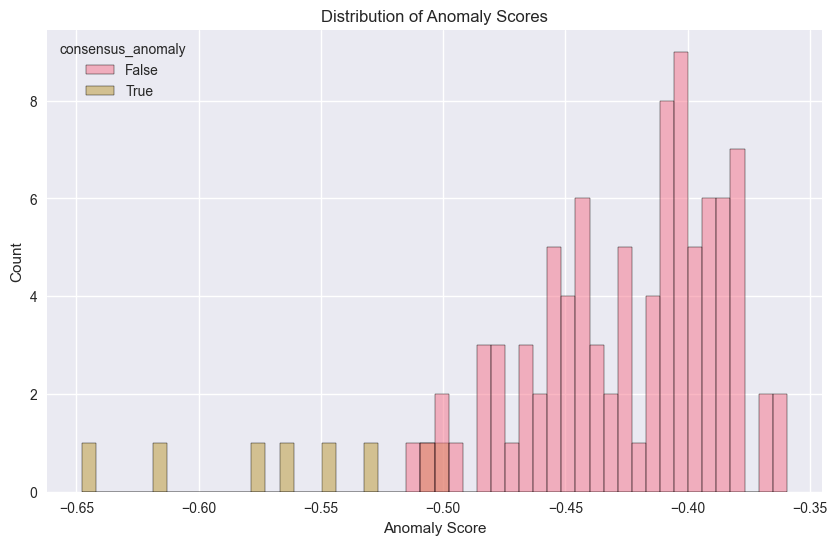

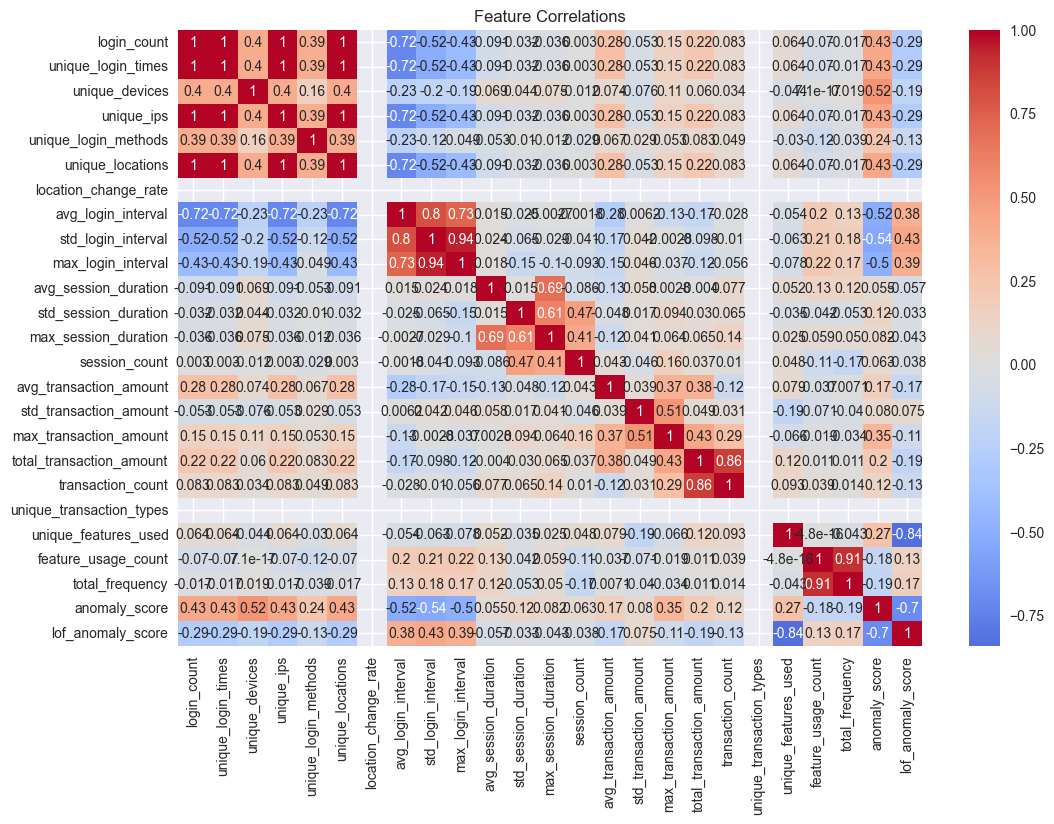

In [94]:
def plot_anomaly_distribution(user_features):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=user_features, x='anomaly_score', hue='consensus_anomaly', bins=50)
    plt.title('Distribution of Anomaly Scores')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Count')
    plt.show()

def plot_feature_correlations(user_features):
    # Select numeric columns
    numeric_cols = user_features.select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col not in ['user_id', 'consensus_anomaly']]
    
    # Calculate correlation matrix
    corr_matrix = user_features[numeric_cols].corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlations')
    plt.show()

# Plot distributions and correlations
plot_anomaly_distribution(user_features_with_anomalies)
plot_feature_correlations(user_features_with_anomalies)

## 5. Save Results

In [95]:
# Create output directory if it doesn't exist
os.makedirs('output', exist_ok=True)
# Save fraudulent users to CSV
fraudlent_users_consensus_anomalies.to_csv('output/fraudulent_users.csv', index=False)
print("Saved fraudulent users to output/fraudulent_users.csv")

# Display summary statistics of fraudulent users
print("\nSummary Statistics of Fraudulent Users:")
display(fraudlent_users_consensus_anomalies.describe())

Saved fraudulent users to output/fraudulent_users.csv

Summary Statistics of Fraudulent Users:


,login_count,unique_login_times,unique_devices,unique_ips,unique_login_methods,unique_locations,location_change_rate,avg_login_interval,std_login_interval,max_login_interval,...,std_transaction_amount,max_transaction_amount,total_transaction_amount,transaction_count,unique_transaction_types,unique_features_used,feature_usage_count,total_frequency,anomaly_score,lof_anomaly_score
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.0,8.000000,8.000000,8.000000e+00,...,8.000000,8.000000,8.000000,8.0000,8.0,8.000000,8.000000,8.000000,8.000000,8.000000
mean,6.375000,6.375000,2.500000,6.375000,2.625000,6.375000,1.0,413285.579415,457447.128352,1.147642e+06,...,2766.653916,8900.543750,76324.480000,16.7500,3.0,4.875000,32.750000,99.625000,-0.560652,1.852430
std,2.445842,2.445842,0.755929,2.445842,0.517549,2.445842,0.0,150624.513962,271675.827521,4.659378e+05,...,511.532297,1088.947941,21794.201346,3.7321,0.0,0.353553,5.470701,20.687729,0.051170,0.853936
min,3.000000,3.000000,1.000000,3.000000,2.000000,3.000000,1.0,216282.125000,165350.556819,4.687060e+05,...,1955.507811,7375.400000,47163.830000,12.0000,3.0,4.000000,24.000000,70.000000,-0.647605,1.304336
25%,4.750000,4.750000,2.000000,4.750000,2.000000,4.750000,1.0,295246.067460,265898.606464,8.278150e+05,...,2488.671176,7753.685000,59020.785000,13.7500,3.0,5.000000,30.000000,89.000000,-0.585577,1.386603
50%,6.000000,6.000000,3.000000,6.000000,3.000000,6.000000,1.0,401873.750000,385429.312205,1.139430e+06,...,2623.293591,9398.435000,73425.535000,17.0000,3.0,5.000000,31.500000,96.500000,-0.555383,1.459536
75%,8.250000,8.250000,3.000000,8.250000,3.000000,8.250000,1.0,511084.537500,628278.770024,1.521489e+06,...,3214.265827,9834.332500,94172.107500,18.5000,3.0,5.000000,36.250000,104.500000,-0.522127,1.883994
max,10.000000,10.000000,3.000000,10.000000,3.000000,10.000000,1.0,647219.333333,945199.971657,1.738599e+06,...,3512.829725,9888.890000,108168.190000,23.0000,3.0,5.000000,42.000000,140.000000,-0.502904,3.821761


#### Explanation for consideration

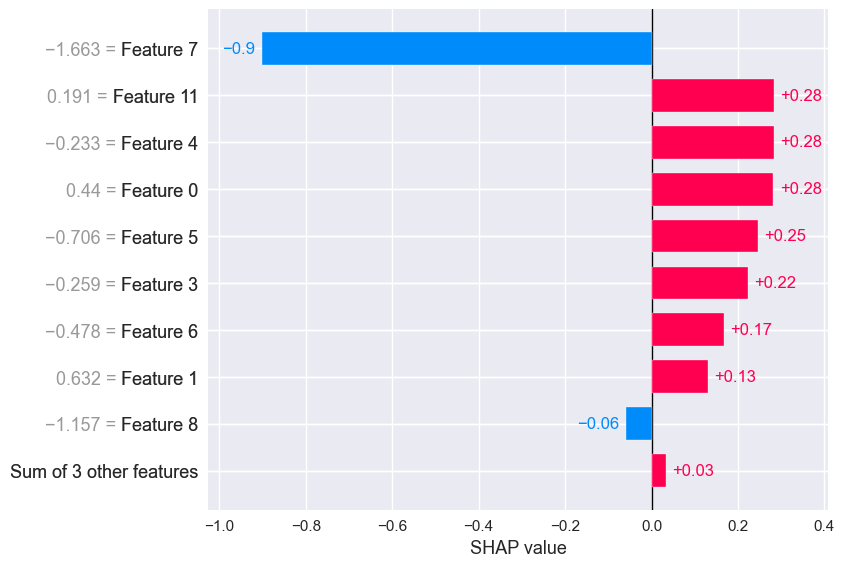

In [96]:
explainer = shap.Explainer(iso_forest, scaled_features)
shap_values = explainer(scaled_features)

# Visualize a single user's explanation
shap.plots.bar(shap_values[0])  # for the first user

### Z-score Threshold Guidelines

1. **Z-score = ±2 (95% confidence)**
   * Captures moderate outliers
   * May include more false positives
   * Use when cost of missing anomalies is high

2. **Z-score = ±3 (99.7% confidence)**
   * Standard threshold for outlier detection
   * Good balance between precision and recall
   * Recommended starting point for fraud detection

3. **Z-score = ±4 (99.99% confidence)**
   * Very conservative threshold
   * High confidence in flagged anomalies
   * Use when false positives are very costly

Choose your threshold based on:
* Your tolerance for false positives
* The cost of missing actual fraud
* The typical variation in your data
* Domain knowledge about fraud patterns

In [100]:
means = X.mean()
stds = X.std()
z_scores = (X - means) / stds
z_scores['user_id'] = user_ids

# Helper to get top contributing anomaly reasons
def get_top_z_reasons(z_row, threshold=2.0):
    reasons = []
    for col in important_features:
        z_val = z_row[col]
        if abs(z_val) > threshold:
            direction = "high" if z_val > 0 else "low"
            reasons.append(f"{col} is too {direction} (z={z_val:.2f})")
    return reasons

user_features['z_score_reasons'] = z_scores.apply(get_top_z_reasons, axis=1)


In [ ]:
import json
from datetime import datetime

# Filter anomalies with both consensus and non-empty reasons
anomalies = user_features[
    (user_features['consensus_anomaly'] == True) & 
    (user_features['z_score_reasons'].str.len() > 0)
][['user_id', 'anomaly_score', 'z_score_reasons']]

print(f"Found {len(anomalies)} anomalies with supporting reasons\n")

# Create JSON structure
anomalies_json = {
    "analysis_timestamp": datetime.now().isoformat(),
    "total_anomalies": len(anomalies),
    "anomalies": []
}

for _, row in anomalies.iterrows():
    anomaly_entry = {
        "user_id": row['user_id'],
        "anomaly_score": float(round(row['anomaly_score'], 3)),
        "reasons": row['z_score_reasons']
    }
    anomalies_json["anomalies"].append(anomaly_entry)
    
    # Print for notebook display
    print(f"User ID: {row['user_id']}")
    print(f"  Anomaly Score: {row['anomaly_score']:.3f}")
    print("  Reasons:")
    for reason in row['z_score_reasons']:
        print(f"   - {reason}")
    print("------------")

# Save to JSON file in output directory
output_file = "output/anomalies_report.json"
with open(output_file, 'w') as f:
    json.dump(anomalies_json, f, indent=2)

print(f"\nReport saved to {output_file}")


Found 8 anomalies with supporting reasons

User ID: USER_000003
  Anomaly Score: -0.648
  Reasons:
   - avg_login_interval is too high (z=3.47)
   - std_login_interval is too high (z=3.11)
   - avg_transaction_amount is too low (z=-2.87)
   - max_transaction_amount is too low (z=-3.09)
------------
User ID: USER_000008
  Anomaly Score: -0.547
  Reasons:
   - avg_login_interval is too high (z=2.21)
   - std_login_interval is too high (z=3.69)
------------
User ID: USER_000013
  Anomaly Score: -0.528
  Reasons:
   - std_transaction_amount is too low (z=-2.46)
   - max_transaction_amount is too low (z=-3.64)
------------
User ID: USER_000034
  Anomaly Score: -0.615
  Reasons:
   - avg_login_interval is too high (z=4.37)
   - std_login_interval is too high (z=5.82)
   - feature_usage_count is too high (z=2.28)
------------
User ID: USER_000043
  Anomaly Score: -0.564
  Reasons:
   - unique_devices is too low (z=-4.42)
   - unique_ips is too low (z=-2.20)
------------
User ID: USER_000045
 